## Pseudocode for simple Airport Leaflet Map

1. Extract airport from downloaded NE data zipfile
2. Convert zipfiled shapefile to `geodataframe`
3. Create `folium` map
4. Add airpoint points to `folium` map
5. Group points based on type
   - Small
   - Mid
   - Major
   - Spaceport
   - Military (mid and military, major and military, military mid, military, military major)
6. Add `tooltips` containing Name + IATA code if there's any
7. Save

In [22]:
# !pip install fiona
# !pip install folium

In [51]:
import folium 
import fiona
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import pandas as pd

In [74]:
# get airport zipfile from Natural Earth Dataset
zipfile = "zip://ne_10m_airports.zip"
airports_raw = gpd.read_file(zipfile)
print(airports_raw.columns)
airports_raw.head()

Index(['scalerank', 'featurecla', 'type', 'name', 'abbrev', 'location',
       'gps_code', 'iata_code', 'wikipedia', 'natlscale', 'comments',
       'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es',
       'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it',
       'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru',
       'name_sv', 'name_tr', 'name_vi', 'name_zh', 'wdid_score', 'ne_id',
       'name_fa', 'name_he', 'name_uk', 'name_ur', 'name_zht', 'geometry'],
      dtype='object')


,scalerank,featurecla,type,name,abbrev,location,gps_code,iata_code,wikipedia,natlscale,...,name_vi,name_zh,wdid_score,ne_id,name_fa,name_he,name_uk,name_ur,name_zht,geometry
0,9,Airport,small,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,8.0,...,None,None,4.0,1159113785,فرودگاه سهنول,None,None,None,None,POINT (75.95707 30.85036)
1,9,Airport,mid,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,8.0,...,None,None,4.0,1159113803,فرودگاه سولاپور,None,None,None,None,POINT (75.93306 17.62542)
2,9,Airport,mid,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,8.0,...,Sân bay Birsa Munda,比尔萨·蒙达机场,4.0,1159113831,فرودگاه بیرسا موندا,None,None,None,比爾薩·蒙達機場,POINT (85.3236 23.31772)
3,9,Airport,mid,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,8.0,...,Sân bay Ahvaz,阿瓦士机场,4.0,1159113845,فرودگاه بین المللی اهواز,None,None,None,阿瓦士機場,POINT (48.74711 31.34316)
4,9,Airport,mid and military,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,8.0,...,Sân bay Gwalior,辛迪亚航空站,4.0,1159113863,فرودگاه گوالیور,None,None,None,辛迪亞航空站,POINT (78.21722 26.28549)


In [106]:
columns_to_retain = ["type", "name", "abbrev", 
                     "location", "gps_code",
                     "iata_code", "natlscale", "geometry"]

airports = airports_raw[columns_to_retain]
airports.head()
airports.geometry.dtype

In [79]:
# see if there are null rows

null_rows = airports[airports.isnull().any(axis=1)]
print(f"There are {null_rows.shape[0]} that have null values.")
null_rows.head(null_rows.shape[0]) # 13 rows -> not very crucial so leave as it is.

There are 13 that have null values.


,type,name,abbrev,location,gps_code,iata_code,natlscale,geometry
23,military mid,Adampur,VIAX,runway,VIAX,None,8.0,POINT (75.75848 31.43294)
24,military,Bareilly,VIBY,runway,VIBY,None,8.0,POINT (79.452 28.42181)
25,small,Dhamial,OPQS,runway,OPQS,None,8.0,POINT (73.03205 33.56141)
228,mid,Burnpur,VE23,runway,VE23,None,10.0,POINT (86.97455 23.63122)
229,mid,Hindon Air Force Station,VIDX,runway,VIDX,None,10.0,POINT (77.35079 28.7078)
230,major,Sunchon,None,runway,None,None,10.0,POINT (125.89083 39.41197)
235,military major,Severomorsk-3 (Murmansk N.E.),ULMM,runway,ULMM,None,10.0,POINT (33.29035 69.01687)
237,military mid,Rostov N.,None,runway,None,None,10.0,POINT (39.6354 47.27742)
238,mid,Rostov S.W.,None,runway,None,None,10.0,POINT (39.79722 47.11586)
277,spaceport,Baikonur Cosmodrome,BAIK,approximate,None,None,10.0,POINT (63.30735 45.96357)


In [80]:
# check if there are duplicate values

dupes = airports[airports.duplicated()]
dupes.shape[0] # returns 0 -> no duplicates

0

## Create point geometries

In [81]:
# get world map
world = geopandas.read_file(geodatasets.get_path("naturalearth.land"))

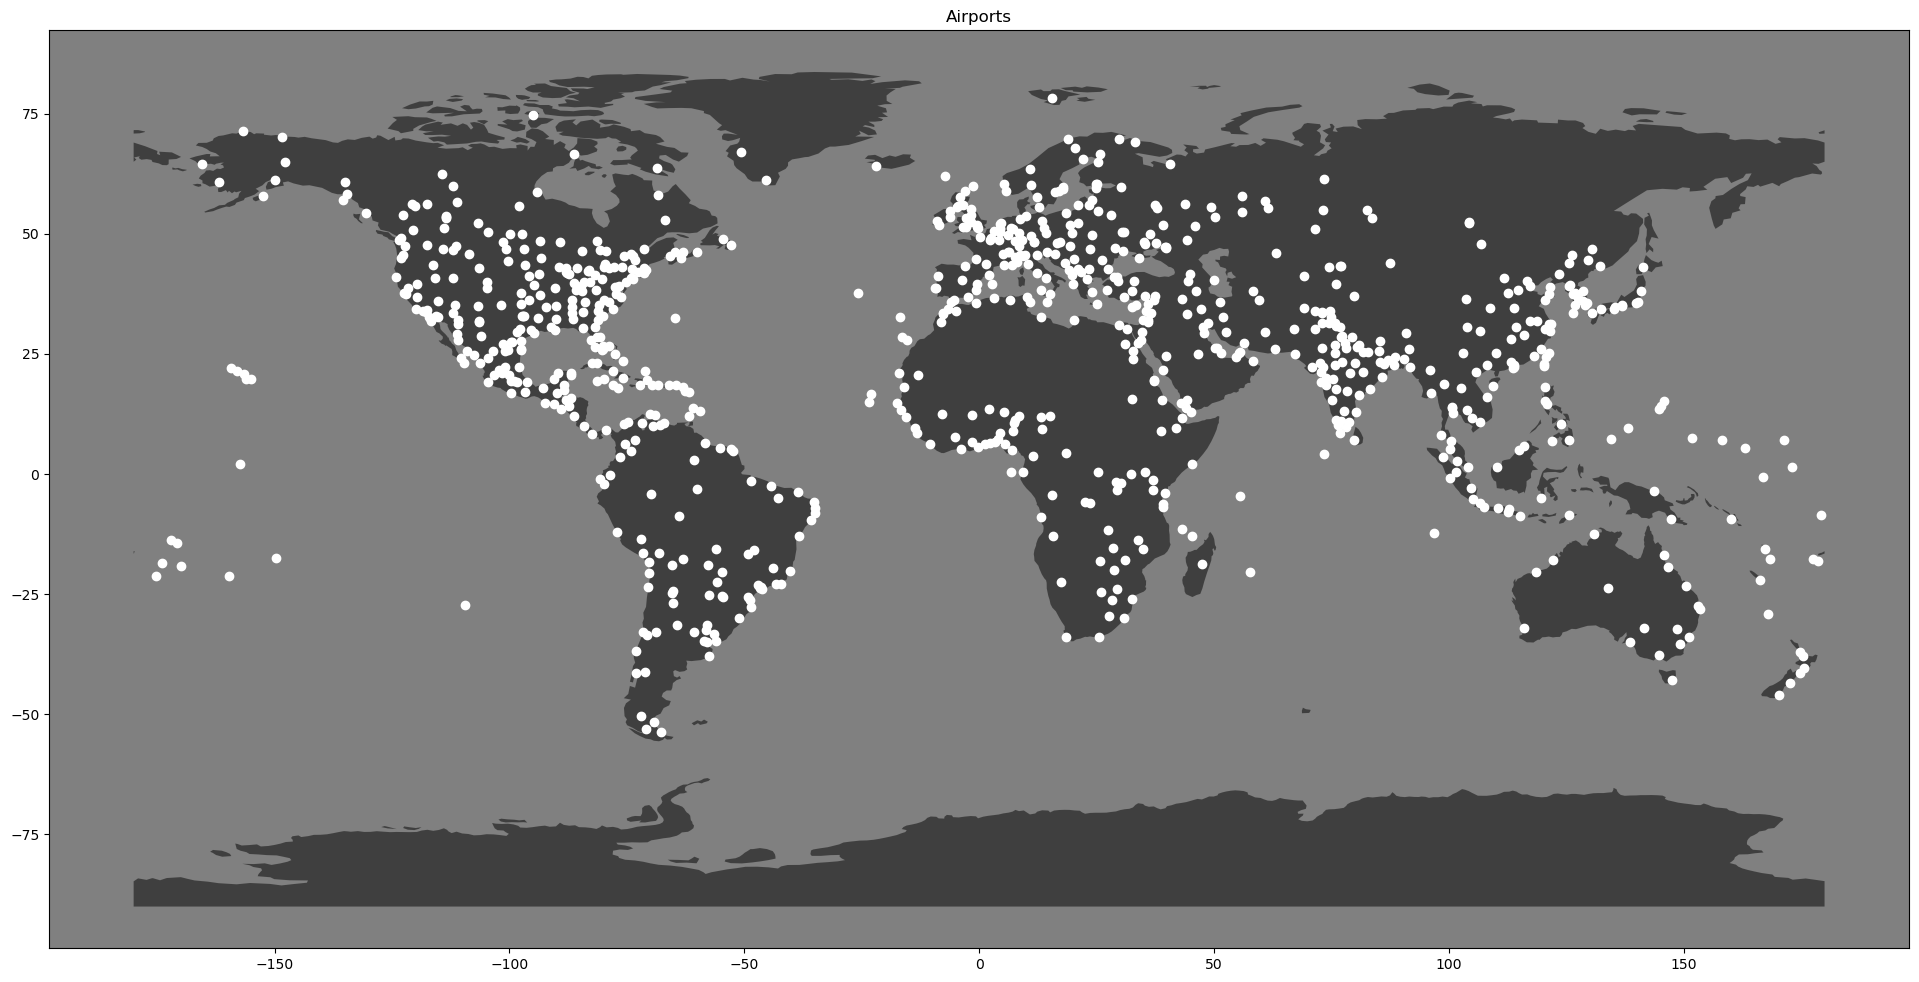

In [96]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.5, color="#000000")
airports.plot(ax=ax, color="white")
ax.set_facecolor('gray')
plt.title("Airports")
plt.show()

In [172]:
# set tiles Stadia_StamenWatercolor, CartoDB_DarkMatter, CartoDB_DarkMatterNoLabels
tiles = "CartoDB_DarkMatter" 
m = folium.Map(location=[0,0], tiles=tiles, max_bounds=True,
               zoom_start=2, min_zoom=2)

airport_legends = {
                    'small': 'pink', 
                    'mid': 'blue', 
                    'major': 'green', 
                    'spaceport': 'darkred', 
                    'military': 'gray'
                  }

military_types = ['military', 'mid and military', 'military mid', 
                  'major and military','military major']

# ['small' 'mid' 'mid and military' 'major and military' 'military mid'
#  'military' 'major' 'military major' 'spaceport']

print(airport_legends)

# create FeatureGroup per airport type
airport_feature_group = {airport_type: folium.FeatureGroup(airport_type).add_to(m)
                        for airport_type in airport_legends.keys()
                        }

# create function to add point marker
def add_point_marker(gdf_row, folium_map):
    """
    inserts the airport location to the map + other details
    :param gdf_row: geopanda series containing airport location
    :param folium_map: the folium map where the points will be overlaid
    :return: none
    """
    coordinates = [gdf_row.geometry.y , gdf_row.geometry.x]
    tooltip = f"{gdf_row["name"]} ({gdf_row["iata_code"]})" if gdf_row["iata_code"] else gdf_row["name"]
            
    airport_type = gdf_row["type"]
    
    if airport_type in military_types:
        color = airport_legends["military"]
        airport_type = "military"
    else:
        color = airport_legends[airport_type]

    folium.Marker(
        location=coordinates,
        tooltip=tooltip ,
        icon=folium.Icon(icon='plane', color=color)
    ).add_to(airport_feature_group[airport_type])


airports.apply(lambda row: add_point_marker(row, m), axis=1)
folium.LayerControl(collapsed=False).add_to(m)
m

{'small': 'pink', 'mid': 'blue', 'major': 'green', 'spaceport': 'darkred', 'military': 'gray'}


In [173]:
m.save("index.html")

In [130]:
print(airports.columns)
print(airports["type"].unique())

# group

Index(['type', 'name', 'abbrev', 'location', 'gps_code', 'iata_code',
       'natlscale', 'geometry'],
      dtype='object')
['small' 'mid' 'mid and military' 'major and military' 'military mid'
 'military' 'major' 'military major' 'spaceport']
